# Gather metadata for software

## Import libraries

In [1]:
import json
import requests
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect metadata for 5,000 software records

## Set variables

In [2]:
BASE_URL = "https://api.figshare.com/v2"

In [7]:
#Gather basic metadata for items (articles) that meet your search criteria
results = []
query = '{"item_type": 9}' #Search for software
y = json.loads(query) #Figshare API requires json paramaters
for j in range(1,6):
    records = json.loads(requests.post(BASE_URL + '/articles/search?page_size=1000&page={}'.format(j), params=y).content)
    results.extend(records)
    
#See the number of articles
print(len(results),'articles retrieved')

5000 articles retrieved


In [8]:
#Save the json.
with open('software'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(results, f)

In [9]:
#Create a dataframe from the JSON formatted data
dfbasic = pd.DataFrame(results)

In [10]:
#Save a file of all the metadata
save_file = dfbasic.to_csv('software-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv')

In [19]:
#Open a file if needed
dfbasic = pd.read_csv('software-2023-05-13.csv',encoding='utf8')

In [11]:
#Create a list of all the article ids
article_ids = dfbasic['id'].tolist()

In [12]:
#article_ids2 = article_ids[12679:16047]
len(article_ids)

5000

In [15]:
item_metadata = []
author_metadata = []
funding_metadata = []
categories_metadata = []
tags_data = []
files_metadata = []
error_count = 0

for item in article_ids:
    m = requests.get(BASE_URL + '/articles/' + str(item))
    metadata=json.loads(m.text)
    
    if m.status_code == 200: #if the record is not a previously published and then unpublished record

        views = json.loads(requests.get('https://stats.figshare.com/total/views/article/' + str(item)).content)
        #Add views to the full metadata record and add to the main list
        metadata['views'] = views['totals']
        item_metadata.append(metadata)

        #Add item id to each set of content for individual tables
        authors = metadata['authors']
        for a in authors:
            a['item_id'] = item
            author_metadata.append(a)

        funding = metadata['funding_list']
        for f in funding:
            f['item_id'] = item
            funding_metadata.append(f)
    
        cats = metadata['categories']
        for c in cats:
            c['item_id'] = item
            categories_metadata.append(c)
    
        for t in metadata['tags']: #tags are a list so its a bit different
            tags = {}
            tags['item_id'] = item
            tags['name'] = t
            tags_data.append(tags)

        if metadata['is_embargoed'] == 0: #If the record is not embargoed
            if len(metadata['files']) > 0: #If the record is not 'metadata only'
                files = metadata['files']
                for f in files:
                    f['item_id'] = item
                    files_metadata.append(f)
    else:
        error_count += 1
    
    
print('Full metadata for',len(item_metadata),'items retrieved.', error_count,'items had an error')


Full metadata for 5000 items retrieved. 0 items had an error


In [16]:
#save the json. 
with open('full_records-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(item_metadata, f)

with open('author-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(author_metadata, f)

with open('funding-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(funding_metadata, f)

with open('categories-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(categories_metadata, f)

with open('tags-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(tags_data, f)

with open('files-'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.json', 'w') as f:
    json.dump(files_metadata, f)

In [17]:
#Create a dataframe from the JSON formatted data
df = pd.DataFrame(item_metadata)
print('Done!')

Done!


## Format the data

### Split out the dates

In [18]:
#The dates are all contained within one column called 'timeline'. Flatten that column and associate the values
#with the proper article id in a new dataframe

temp_date_list = []

for item in item_metadata:
    dateitem = item['timeline']
    dateitem['id'] = item['id']
    temp_date_list.append(dateitem)

df_dates = pd.json_normalize(
    temp_date_list 
)

df_dates.replace(df_dates.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

#Merge the dataframes
df_formatted = df.merge(df_dates, how='outer', on='id')

print("Dates split out and merged")

Dates split out and merged


### Remove columns in main set that are not separate tables

In [63]:
df_formatted = df_formatted.drop(columns=['files', 'authors','funding','funding_list','tags','categories','timeline'])

### If group_id is not null, then assign the record a institutional/publisher tag. Otherwise, figshare.com

In [69]:
df_formatted['origin'] = 'figshare-user' #create a new column and fill with default values
df_formatted['edited_group_id'] = df_formatted['group_id']
df_formatted['edited_group_id'].replace(np.nan, 999999999999, inplace=True)
df_formatted.loc[df_formatted['edited_group_id'] != 999999999999, 'origin'] = 'organization'

<ipython-input-69-5b552e991963>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df_formatted['edited_group_id'].replace(pd.np.nan, 999999999999, inplace=True)


### Replace blanks with 'null' and rename id column

In [72]:
df_formatted.replace(df_formatted.replace(r'^\s*$', np.nan, regex=True, inplace = True)) #Replace blank cells with 'null'
#df_formatted.embargo_date.fillna(value='null', inplace=True)
df_formatted.fillna(value='null', inplace=True)
df_formatted = df_formatted.rename(columns={'id': 'item_id'}) #Rename id col in main dataframe

## Create all other dataframes

In [10]:
authorsdf = pd.json_normalize(author_metadata)
authorsdf.replace(authorsdf.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

fundersdf = pd.json_normalize(funding_metadata)
fundersdf.replace(fundersdf.replace(r'^\s*$', 'null', regex=True, inplace = True)) #Replace blank cells with 'null'

categoriesdf = pd.json_normalize(categories_metadata)

tagsdf = pd.DataFrame(tags_data, columns=["item_id","name"], index=None)

filesdf = pd.json_normalize(files_metadata)

### Save to one excel book

In [73]:
with pd.ExcelWriter("metadata.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_formatted.to_excel(writer, sheet_name="main", index=False)
    authorsdf.to_excel(writer, sheet_name="authors", index=False)
    fundersdf.to_excel(writer, sheet_name="funding", index=False)
    categoriesdf.to_excel(writer, sheet_name="categories", index=False)
    tagsdf.to_excel(writer, sheet_name="tags", index=False)
    filesdf.to_excel(writer, sheet_name="files", index=False)

In [11]:
#Save to separate CSVs if you want
save_file = authorsdf.to_csv('authors.csv',encoding='utf-8', index=None)

save_file = fundersdf.to_csv('funding.csv',encoding='utf-8', index=None)

save_file = categoriesdf.to_csv('categories.csv',encoding='utf-8', index=None)

save_file = tagsdf.to_csv('tags.csv',encoding='utf-8', index=None)

save_file = filesdf.to_csv('files.csv',encoding='utf-8', index=None)

save_file = df_formatted.to_csv('main.csv',encoding='utf-8', index=None)

In [9]:
#If you need to open json files

with open("author-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    author_metadata = json.load(read_file)

with open("funding-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    funding_metadata = json.load(read_file)

with open("categories-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    categories_metadata = json.load(read_file)
    
with open("tags-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    tags_data = json.load(read_file)
    
#For some reason files json never got saved.


# Analysis

In [ ]:
#Open a file if needed
df = pd.read_csv('main.csv',encoding='utf8')
authorsdf = pd.read_csv('authors.csv',encoding='utf8')
fundersdf = pd.read_csv('funding.csv',encoding='utf8')
categoriesdf = pd.read_csv('categories.csv',encoding='utf8')
tagsdf = pd.read_csv('tags.csv',encoding='utf8')
filesdf = pd.read_csv('files.csv',encoding='utf8')

In [ ]:
#simplify the dataframe name if you are doing this from the beginning
#df = df_formatted

### Set parameters for charts

In [23]:
#parameters
chart_title_font = 25
y_axis_label_font = 15
x_tick_size = 20
y_tick_size = 20
startfont = 30

#set color properties for box plots https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn
PROPS = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

colors = ["#D9D9D9","#5A5A5A"] #"#FFFFFF"

### What domains are present?

In [38]:
from collections import Counter

In [36]:
with open("software2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    basic_metadata = json.load(read_file)

In [39]:
#Look at the institutions represented
url = []
for s in basic_metadata:
    url.append(s['url_public_html'][8:22])

unique_domains = Counter(url)
unique_domains

Counter({'figshare.com/a': 3195,
         'data.ncl.ac.uk': 41,
         'opticapublishi': 99,
         'bridges.monash': 37,
         'jstagedata.jst': 6,
         'rdr.ucl.ac.uk/': 15,
         'aacr.figshare.': 1026,
         'data.dtu.dk/ar': 12,
         'rs.figshare.co': 26,
         'smithsonian.fi': 2,
         'plos.figshare.': 24,
         'researchdata.u': 6,
         'figshare.shef.': 26,
         'cord.cranfield': 12,
         'datahub.hku.hk': 9,
         'rmit.figshare.': 5,
         'iastate.figsha': 2,
         'uvaauas.figsha': 19,
         'figshare.scili': 3,
         'figshare.manch': 21,
         'su.figshare.co': 4,
         'kcl.figshare.c': 8,
         'arizona.figsha': 5,
         'data.4tu.nl/ar': 136,
         'repository.lbo': 7,
         'springernature': 45,
         'dayta.nwu.ac.z': 5,
         'melbourne.figs': 35,
         'datarepository': 6,
         'epa.figshare.c': 4,
         'plus.figshare.': 5,
         'federation.fig': 1,
         'ordo.open

In [42]:
origindf = df.groupby(by=['origin']).count().reset_index()

In [44]:
origindf

#So there is one record that may or may not be figshare.com, but this aligns well with the domains

,origin,custom_fields,figshare_url,description,version,status,size,created_date,modified_date,is_public,...,resource_title,resource_doi,views,posted,firstOnline,publisherPublication,publisherAcceptance,edited_group_id,year_posted,month_posted
0,figshare-user,3196,3196,3196,3196,3196,3196,3196,3196,3196,...,2,2,3196,3195,3195,0,0,3196,3195,3195
1,organization,1804,1804,1804,1804,1804,1804,1804,1803,1804,...,1374,1374,1804,1804,1804,1061,35,1804,1804,1804


### Look at records over time

<ipython-input-15-620fbb069599>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize = 12)


[Text(0, 0.0, '0.0'),
 Text(0, 500.0, '500.0'),
 Text(0, 1000.0, '1000.0'),
 Text(0, 1500.0, '1500.0'),
 Text(0, 2000.0, '2000.0'),
 Text(0, 2500.0, '2500.0')]

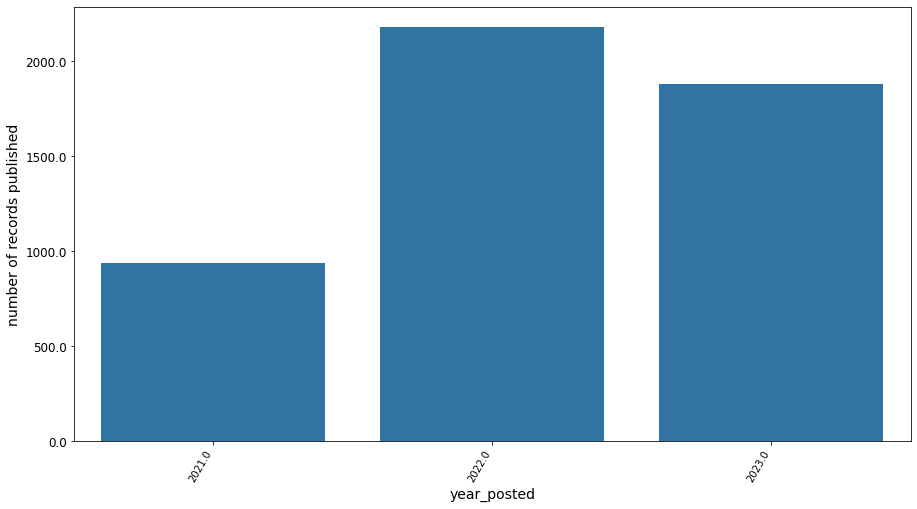

In [15]:
#Use the posted date because the firstOnline date may not align with the actual Figshare record. 
#The posted date as this is the date posted on Figshare.

#Add year and month posted columns
df['year_posted'] = pd.DatetimeIndex(df['posted']).year
df['month_posted'] = pd.DatetimeIndex(df['posted']).month

#Another way to do it...Split the year out and add it as a column
#year = df_full["firstOnline"].str.split("-", n = 1, expand = True)
#df_full['year'] = year[0]

#Group by year
datechart = df.groupby(['year_posted']).count().reset_index()

#Chart it all out
#sns.color_palette("husl", 8)
plt.rcParams["figure.figsize"] = (15,8)
ax = sns.barplot(data=datechart, x="year_posted", y="item_id", palette=["C0"])
#ax.set(xlabel='year', ylabel='number of records published')
ax.set_ylabel("number of records published", fontsize = 14)
ax.set_xlabel("year_posted", fontsize = 14)
ax.set_xticklabels(datechart['year_posted'], fontsize = 10, rotation=60, ha="right")
ax.set_yticklabels(ax.get_yticks(), fontsize = 12)

## Views per time
Really should use first online date. see this example: https://figshare.shef.ac.uk/articles/dataset/CoVid_Plots_and_Analysis/12328226 If things are versioned then the posted date and views no longer align it seems

In [16]:
dfviews = df.copy() 

In [20]:
#There is at least one missing firstOnline date so replace that with the posted date just in this dataframe
dfviews['firstOnline'].fillna(dfviews['posted'], inplace=True)

In [21]:
#----!!!!!!!! Adjust the values for your data collection date

current_month = 5
current_year = 2023

def calc(row):
    if row['month_posted'] != current_month and row['year_posted'] == current_year: #number of months from current year
        return (current_month-row['month_posted'])
    elif row['month_posted'] == current_month and row['year_posted'] == current_year: #If published in current month and year
        return 0.75 #data was collected on Oct 26 so if item posted this september just assign it 0.75
    else:
        return ((current_year-(row['year_posted']+1))*12)+(12-row['month_posted'])+current_month #add 1 to the posted year first then subtract to get full years, then add the months from posted year, then months for current year

    
dfviews['months_since_posted'] = dfviews.apply(calc, axis=1)


dfviews['views_per_month'] = dfviews['views']/dfviews['months_since_posted']
dfviews['log_views_per_month'] = np.log(dfviews['views_per_month'])
#df['downloads_per_month'] = df['downloads']/df['months_since_posted']

#Save to CSV
#dfviews.to_csv('DeleteExamineViews.csv', index = False, header=True)

c:\users\andre.desktop-dfg3gu2\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


c:\users\andre.desktop-dfg3gu2\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 1.0, 'Log Views per Month')

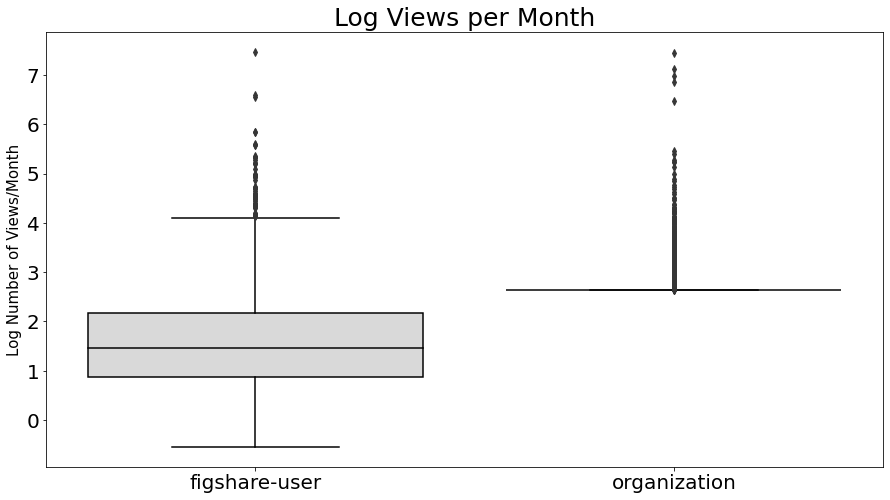

In [24]:
#Create a chart


ax = sns.boxplot(data=dfviews, x='origin', y='log_views_per_month', palette=sns.color_palette(colors, 2),**PROPS)#, palette="Blues_d")
ax.set(xlabel=None)
xticks = plt.xticks()
#wrap_labels(ax,14)
ax.set_ylabel('Log Number of Views/Month', fontsize=y_axis_label_font)
ax.tick_params(axis='x', which='major', labelsize=x_tick_size)
ax.tick_params(axis='y', which='major', labelsize=y_tick_size)
ax.set_title('Log Views per Month', fontsize=chart_title_font)
#ax.text(0.5, 0.8,'*', ha='center', fontsize = startfont, transform=ax6.transAxes)


#Save Figure
#plt.savefig('viewsmonth-color-pres.jpg', dpi=180, format="jpg")

### Examine Files

In [30]:
filesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12636 entries, 0 to 12635
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            12636 non-null  int64 
 1   name          12633 non-null  object
 2   size          12636 non-null  int64 
 3   is_link_only  12636 non-null  bool  
 4   download_url  12636 non-null  object
 5   supplied_md5  12593 non-null  object
 6   computed_md5  12523 non-null  object
 7   item_id       12636 non-null  int64 
dtypes: bool(1), int64(3), object(4)
memory usage: 703.5+ KB


In [45]:
linked_record = filesdf.groupby(by=['is_link_only']).count().reset_index()
linked_record

,is_link_only,id,name,size,download_url,supplied_md5,computed_md5,item_id,ext_pullout,extension
0,False,12593,12593,12593,12593,12593,12523,12593,12593,12444
1,True,43,40,43,43,0,0,43,40,7


### Look for README


In [31]:

readme1 = filesdf[filesdf['name'].str.contains("README") | filesdf['name'].str.contains("readme")]

prop_readmes = (len(readme1['item_id'].unique()))/len(filesdf)

print(len(readme1), "files are named README or readme")
print('Representing',len(readme1['item_id'].unique()),'records')

221 files are named README or readme
Representing 211 records


### File extensions

In [34]:
#
filesdf['ext_pullout'] = filesdf['name'].str[-6:] #create col with last six digits
temp_df = filesdf['ext_pullout'].str.split(".", n = 1, expand = True)  # Split string once on the period, expand to new columns in new df  
filesdf['extension'] = temp_df[1] #Then add the extension column from the temp df to the current df

extensions = filesdf['extension'].value_counts().to_frame().reset_index().rename(
           columns={'index': 'file_type', 'extension': 'count'})

extensions['proportion'] = extensions['count']/len(filesdf) #Add a proportion col

In [35]:
extensions.head(20)

,file_type,count,proportion
0,zip,2783,0.220244
1,m,1823,0.144270
2,R,1252,0.099082
3,py,705,0.055793
4,txt,686,0.054289
5,gz,373,0.029519
6,ipynb,371,0.029361
7,csv,334,0.026432
8,sigml,328,0.025958
9,pdf,270,0.021368


### Github References

In [33]:
#Look in the references field - this is number of ITEMS with at least one github reference in references
gitref = df[df['references'].str.contains("github")]


print(len(gitref), "items have at least one github reference")
print('Representing',len(gitref['item_id'].unique()),'records')

572 items have at least one github reference
Representing 572 records


In [60]:
#Look in the description field
gitdesc = df[df['description'].str.contains(".github")]

print(len(gitdesc), "items have at least one github reference")
print('Representing',len(gitdesc['item_id'].unique()),'records')

200 items have at least one github reference
Representing 200 records


In [62]:
#Okay, how many records wtih github in description don't have a reference?
ref_id_list = gitref['item_id'].tolist()
desc_id_list = gitdesc['item_id'].tolist()
#This next line coverts to sets and returns a list of unique entries from the first list.
desc_uniques = list(set(desc_id_list) - set(ref_id_list))
len(desc_uniques)

132

#### So a total of 704 (572+132) items have at least one .github link in either the description or references

In [63]:
len(df)

5000

### What are the common domains in references?

In [46]:
with open("full_records-2023-05-13.json", "r", encoding='utf8') as read_file: #Replace this with the filename of your choice
    full_metadata = json.load(read_file)

In [56]:
#Look at the institutions represented
url = []
for s in full_metadata:
    if len(s['references']) > 0:
        for r in s['references']:
            url.append(r[8:14])

unique_domains = Counter(url)
len(unique_domains)

392

In [59]:
#The github value here is a little bigger than above becuase items have more than one github reference
refs = pd.DataFrame.from_dict(unique_domains, orient='index').reset_index().rename(
           columns={'index': 'url', 0: 'count'})
refs = refs.sort_values(by='count', ascending=False)
refs.head(10)

,url,count
0,github,580
3,doi.or,276
43,gitlab,38
6,arxiv.,35
39,esolve,19
63,journa,18
36,m9.fig,15
159,scienc,13
26,www.bi,12
254,jama.2,12


### Look at licenses

In [64]:
#Look at license list
df['license'].value_counts()

{'value': 1, 'name': 'CC BY 4.0', 'url': 'https://creativecommons.org/licenses/by/4.0/'}                                                      2911
{'value': 52, 'name': 'CC BY', 'url': 'https://creativecommons.org/licenses/by/4.0/'}                                                         1031
{'value': 3, 'name': 'MIT', 'url': 'https://opensource.org/licenses/MIT'}                                                                      454
{'value': 6, 'name': 'GPL 3.0+', 'url': 'https://www.gnu.org/licenses/gpl-3.0.html'}                                                           197
{'value': 2, 'name': 'CC0', 'url': 'https://creativecommons.org/publicdomain/zero/1.0/'}                                                       160
{'value': 7, 'name': 'Apache 2.0', 'url': 'https://www.apache.org/licenses/LICENSE-2.0.html'}                                                   68
{'value': 94, 'name': 'GPL-3.0', 'url': 'https://www.gnu.org/licenses/gpl-3.0.html'}                                  

### A look at tags

In [70]:
tops = tagsdf['name'].value_counts() #this is a series
tops = tops.to_frame()
tops.sort_values(by='name', ascending=False)

tops.head(20)

,name
Bioinformatics,234
Immunology,217
Carcinogenesis,189
"Progression, Invasion & Metastasis",183
Preclinical Models,171
Gastrointestinal Cancers,157
Cell Signaling,155
Small Molecule Agents,147
Breast Cancer,146
Animal models of cancer,131


### Look at categories

In [73]:
tops = categoriesdf['title'].value_counts() #this is a series
tops = tops.to_frame()
tops.sort_values(by='title', ascending=False)

tops.head(20)

,title
Cancer,1039
Therapeutic Research and Development,393
Molecular and Cellular Biology,390
Bioinformatics and computational biology not elsewhere classified,374
Methods and Technology,310
Tumor Biology,269
Immuno-oncology,253
Cancer Biology,250
Software engineering not elsewhere classified,216
Ecology not elsewhere classified,153


# OLD

In [74]:
#Are any missing stats?
missing_stats = df[df['views'].isna()]
missing_stats.head()

,custom_fields,figshare_url,description,version,status,size,created_date,modified_date,is_public,is_confidential,...,resource_doi,views,posted,firstOnline,publisherPublication,publisherAcceptance,origin,edited_group_id,year_posted,month_posted
